# Contrastive Learning
In questo file troviamo un modello di rete neurale per la classificazione del dataset COVID-CXR4.\
IL dataset è stato scaricato da [Kaggle](https://www.kaggle.com/datasets/andyczhao/covidx-cxr2) e messo dentro la cartella datasets \(questa cartella è ignorata da git perchè il dataset è grosso)\
I modelli salvati si possono trovare sotto la cartella [models](models) in modo da poterli usare senza rifare l'addestramento.

Questo *interactive pyhon notebook* è stato diviso in 3 parti principali:
- **Autoencoder**: in cui viene creato l'autoencoder.
- **Classifier**: in cui viene creato il classificatore.
- **Contrastive Learning**: in cui viene applicata la tecnica di contrastive learning per migliorare gli embedding da passare al classificatore.

Ogni parte del notebook contiene anche dei grafici e immagini per mostrare come i vari modelli si comportano.\
In questa prima parte vengono importati le varie librerie usate e vengono create le variabili globali.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, callbacks, ops, backend
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score

root = '../..'
dataset_path = f"{root}/datasets/covid_cxr_embeddings.npz"
predictions_path = f"{root}/datasets/covid_cxr_predictions.npz"
model_save_path = f"{root}/models/siamese.keras"
classifier_path = f"{root}/models/classifier.keras"

temperature = 1
epochs = 10
batch = 32

Qui prendiamo tutti i dati necessari per la creazione del dataset

In [2]:
dataset = np.load(dataset_path, allow_pickle=True)

x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']

predictions = np.load(predictions_path, allow_pickle=True)
y_train_pred = predictions['y_train_pred']
y_val_pred = predictions['y_val_pred']
y_test_pred = predictions['y_test_pred']

latent_space = x_train.shape[1]

Di seguito creiamo le coppie di dati in modo che prendano le rappresentazioni etichettate in modo errato e quelle etichettate correttamente:
- coppie positive se la classe originaria è uguale
- coppie negative se la classe originaria è diversa

In [4]:
def make_pairs_generator(x, y_true, y_pred, batch):
    classes = len(np.unique(y_true))
    correct_predictions = np.where(y_true == y_pred)[0]
    correct_predictions_class = [np.where(y_true[correct_predictions] == i)[0] for i in range(classes)]

    not_correct = np.where(y_true != y_pred)[0]
    yield len(not_correct)

    while True:
        np.random.shuffle(not_correct)
        for i in not_correct:
            pairs_1 = []
            pairs_2 = []
            labels = []

            for _ in range(batch // 2):
                # Positive pair
                x1 = x[i]
                label1 = y_true[i]
                x2 = x[np.random.choice(correct_predictions_class[label1])]
                pairs_1 += [x1]
                pairs_2 += [x2]
                labels += [0]

                # Negative pair
                label2 = np.random.choice(classes)
                while label2 == label1:
                    label2 = np.random.choice(classes)
                idx = np.random.choice(correct_predictions_class[label2])
                x2 = x[idx]
                pairs_1 += [x1]
                pairs_2 += [x2]
                labels += [1]
            yield (np.array(pairs_1), np.array(pairs_2)), np.array(labels)

gen_train_pair = make_pairs_generator(x_train, y_train, y_train_pred, batch)
gen_val_pair = make_pairs_generator(x_val, y_val, y_val_pred, batch)
batch_train_pairs_steps = next(gen_train_pair)
batch_val_pairs_steps = next(gen_val_pair)

print(f"Train pairs: {batch} * {batch_train_pairs_steps}")
print(f"Validation pairs: {batch} * {batch_val_pairs_steps}")

Train pairs: 32 * 3139
Validation pairs: 32 * 533


Questo codice implementa due loss functions.\
In particolare per problemi di apprendimento contrastivo, come il confronto tra coppie di campioni vengono usate le seguenti loss:

1. contrastive_loss: calcola la perdita contrastiva standard.\
   Penalizza le coppie di campioni in base alla loro distanza predetta (y_pred) e alla loro etichetta reale (y_true).\
   Se i campioni sono simili (y_true=0), penalizza le distanze grandi.\
   Se i campioni sono diversi (y_true=1), penalizza le distanze piccole.
2. contrastive_SNN_loss: calcola una variante della perdita contrastiva basata su una funzione softmax normalizzata.\
   Utilizza una temperatura (temperature) per controllare la "morbidezza" della penalizzazione.\
   Penalizza le coppie in base alla probabilità relativa di similarità, calcolata come rapporto tra le distanze esponenziali normalizzate.\
   La loss usata è la [Soft Nearest Neighbors Loss](https://lilianweng.github.io/posts/2021-05-31-contrastive/#soft-nearest-neighbors-loss)

In [5]:
def distance(vects):
    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, backend.epsilon()))

def loss(margin=1.0, temperature=1.0):
    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    def contrastive_SNN_loss(y_true, y_pred):
        mask = ops.equal(y_true, 0)
        exp_similarity = ops.exp(ops.negative(y_pred / temperature))

        numerator = ops.sum(exp_similarity * mask)
        denominator = ops.sum(exp_similarity) + backend.epsilon()  # Add epsilon to avoid division by zero

        safe_ratio = numerator / denominator
        safe_ratio = ops.maximum(safe_ratio, backend.epsilon())  # Ensure ratio is not less than epsilon

        return ops.negative(ops.mean(ops.log(safe_ratio)))

    def contrastive_SL(y_true, y_pred):
        mask = ops.equal(y_true, 0)
        z = (mask - 0.5) * 2

    return contrastive_SNN_loss


Il blocco di codice sottostante definisce un modello siamese che utilizza la loss contrastive per modificare gli embedding in modo da migliorare la classificazione.\
Il modello contrastivo è un semplice modello con pochi layer densi che produce un output scalare con attivazione sigmoid, rappresentando la probabilità che due input appartengano alla stessa classe.\
Il modello siamese utilizza due torri identiche del modello contrastivo per calcolare la distanza tra due rappresentazioni latenti, utilizzando una funzione Lambda personalizzata per calcolare la distanza.

In [6]:
correction_in = layers.Input(shape=(latent_space,))
x = layers.BatchNormalization()(correction_in)
x = layers.Dense(latent_space)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(latent_space)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(latent_space)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
correction_out = layers.Dense(latent_space, activation='sigmoid')(x)
correction = models.Model(correction_in, correction_out, name='correction')

siamese_in_1 = layers.Input(shape=(latent_space,))
siamese_in_2 = layers.Input(shape=(latent_space,))
siamese_tower_1 = correction(siamese_in_1)
siamese_tower_2 = correction(siamese_in_2)
x = layers.Lambda(distance, output_shape=(1,))([siamese_tower_1, siamese_tower_2])
x = layers.BatchNormalization()(x)
siamese_out = layers.Dense(1, activation="sigmoid")(x)
siamese = models.Model([siamese_in_1, siamese_in_2], siamese_out, name='siamese')
siamese.compile(optimizer='adam', loss=loss(1.0, temperature), metrics=['accuracy', None])
siamese.summary()

Model: "siamese"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ correction          │ (None, 1024)      │  4,214,784 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ correction[0][0], │
│                     │                   │            │ correction[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,214,790 (16.08 MB)

 Trainable params: 4,206,596 (16.05 MB)

 Non-trainable params: 8,194 (32.01 KB)

In [7]:
history = siamese.fit(gen_train_pair, validation_data=gen_val_pair,
                      epochs=epochs, batch_size=batch,
                      steps_per_epoch=batch_train_pairs_steps, validation_steps=batch_val_pairs_steps,
                      callbacks=[callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')])

Epoch 1/10
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6609 - loss: 0.5895 - val_accuracy: 0.5428 - val_loss: 0.6750
Epoch 2/10
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6795 - loss: 0.5635 - val_accuracy: 0.6706 - val_loss: 0.5745
Epoch 3/10
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6897 - loss: 0.5535 - val_accuracy: 0.5949 - val_loss: 0.6324
Epoch 4/10
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6883 - loss: 0.5555 - val_accuracy: 0.6528 - val_loss: 0.5868
Epoch 5/10
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6875 - loss: 0.5577 - val_accuracy: 0.6288 - val_loss: 0.6148
Epoch 6/10
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6892 - loss: 0.5566 - val_accuracy: 0.6436 - val_loss: 0.5996
Epoch 7/10
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6957 - loss: 0.5496 - val_accuracy: 0.6578 - val_loss: 0.5849
Epoch 8/10
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.6893 - loss: 0

### Risultati


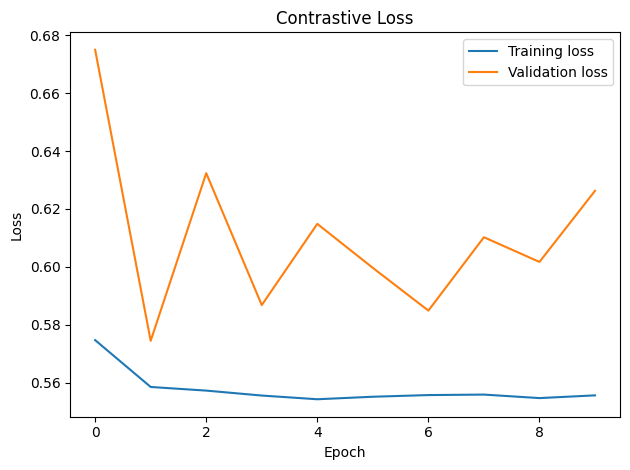

In [8]:
plt.figure(figsize=None)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title(f'Contrastive Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

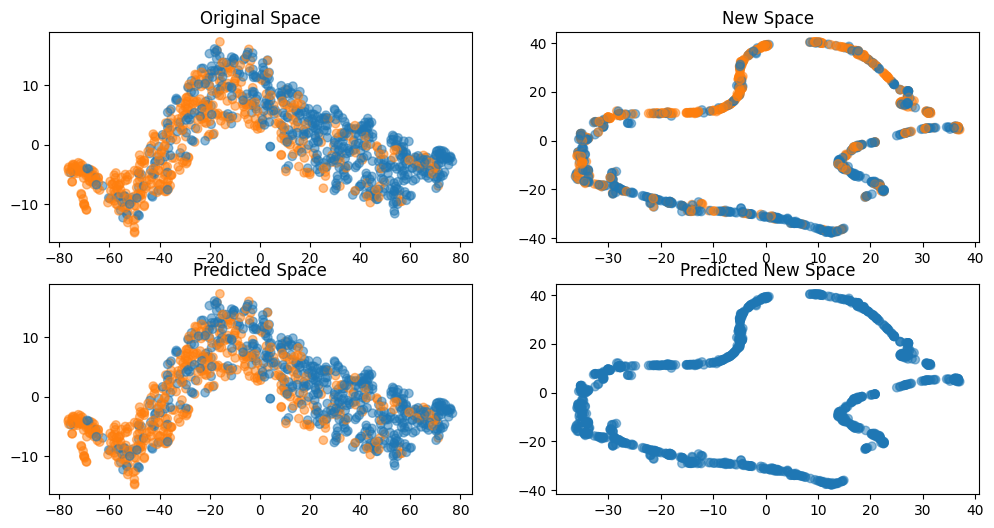

In [10]:
from sklearn.manifold import TSNE as dim_reduction
#from sklearn.decomposition import PCA as dim_reduction
classifier = models.load_model(classifier_path)

# Get sample batch
indices = np.random.choice(len(x_test), 1000, replace=False)
embedded_true = x_test[indices]
embedded_new = correction.predict(embedded_true, verbose=0)
labels_true = y_test[indices]
labels_pred = y_test[indices]
labels_new = np.argmax(classifier.predict(embedded_new, verbose=0), axis=1)

# Get low-dimensional Embeddings
h_embedded_true = dim_reduction(n_components=2).fit_transform(embedded_true)
h_embedded_new = dim_reduction(n_components=2).fit_transform(embedded_new)

# Plot
total_classes = len(np.unique(labels_true))
colors = list(plt.cm.tab10.colors[:total_classes])
colors_true = [colors[i] for i in labels_true]
colors_pred = [colors[i] for i in labels_pred]
colors_new = [colors[i] for i in labels_new]

spaces = [
    (h_embedded_true, colors_true, 'Original Space'),
    (h_embedded_new, colors_true, 'New Space'),
    (h_embedded_true, colors_pred, 'Predicted Space'),
    (h_embedded_new, colors_new, 'Predicted New Space')
]

plt.figure(figsize=(12, 6))
for i, (h, colors, title) in enumerate(spaces):
    plt.subplot(2, 2, i + 1)
    plt.scatter(h[:,0], h[:,1], alpha=0.5, c=colors)
    plt.title(title)
plt.show()

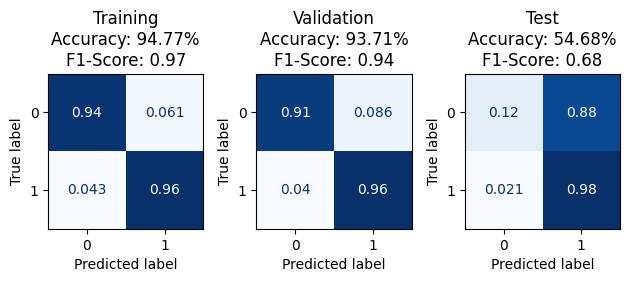

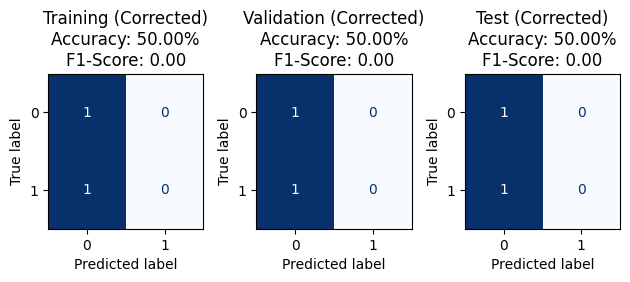

In [13]:
all_datasets = []
all_datasets.append([
    ("Training", y_train, y_train_pred),
    ("Validation", y_val, y_val_pred),
    ("Test", y_test, y_test_pred),
])

y_train_new = np.argmax(classifier.predict(correction.predict(x_train, verbose=0), verbose=0), axis=1)
y_val_new = np.argmax(classifier.predict(correction.predict(x_val, verbose=0), verbose=0), axis=1)
y_test_new = np.argmax(classifier.predict(correction.predict(x_test, verbose=0), verbose=0), axis=1)

all_datasets.append([
    ("Training (Corrected)", y_train, y_train_new),
    ("Validation (Corrected)", y_val, y_val_new),
    ("Test (Corrected)", y_test, y_test_new),
])

for datasets in all_datasets:
    _, axes = plt.subplots(1, len(datasets), figsize=None)
    for i, (title, y_true, y_pred) in enumerate(datasets):
        ConfusionMatrixDisplay.from_predictions(
            y_true,
            y_pred,
            normalize='true',
            display_labels=[i for i in range(total_classes)],
            cmap=plt.cm.Blues,
            colorbar=False,
            ax=axes[i]
        )
        axes[i].set_title(f"{title}\n"
                            + f"Accuracy: {balanced_accuracy_score(y_true, y_pred):.2%}\n"
                            + f"F1-Score: {f1_score(y_true, y_pred):.2f}")
    plt.tight_layout()
    plt.show()

